# TUSNet - Inference

This notebook provides a streamlined workflow for running inference with TUSNet, a deep-learning model designed for transcranial ultrasound (TUS) simulation and phase aberration correction. It includes step-by-step procedures for setting up dependencies, loading in your skull CT scans, initializing the models, and performing inference using a pretrained TUSNet model. The notebook also features visualization tools and metric calculations, including comparisons with k-Wave simulations, to evaluate model performance. We also provide functions for saving these results.

## Imports & Setup

In [1]:
## ----- ADD PATH ----- ##
import os, sys
sys.path.insert(0, os.getcwd() + "/src/")

## ----- IMPORTS ------ ##
from imports import *

## ----- HIGH-RES FIGURES ------ ##
%config InlineBackend.figure_format='retina'

## ----- FIGURE PATH ------ ##
current_path = os.getcwd()
fig_path = current_path + "/figures/"

## ----- NORMALIZATION ------ ##
skull_norm = 2734.531494140625
field_norms_norm = 725208.1250
phase_norm = 1.8769439570576196e-05

## ----- DEVICE ------ ##
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if  torch.backends.mps.is_available() else "cpu")
to_t = lambda array: torch.tensor(array, device=device, dtype=torch.float32)

## Inference

### Dataloader from Skulls

We start by loading the validation data and defining our dataloader. In our setup, val_data is a tuple containing the skull CTs, normalized (0-1) k-Wave simulated pressure fields, k-Wave simulated phases, pressure field normalization factors (the max pressure of each pressure field), and indices corresponding to the ultrasound target in each simulation. Our `CustomDatasetTrace` class uses these indices to determine the (x,y) location of the target and trace waveguides from the edges of the transducer to the target, but this can be easily modified to support specific applications. 

In [35]:
# load validation data
# val_data = import_validation_data(current_path)

# define dataloader
# dataloader = DataLoader(CustomDatasetTrace(device, *val_data), batch_size = 16)

In [ ]:
## ------------------------
## LOAD IN YOUR DATA HERE!
## ------------------------

### Create Models

We define our models and put them on a GPU if available.

In [8]:
pfmodel = LSTMConvBlock(device).to(device)

In [3]:
phasemodel = PhaseDecoder(device, ch_mult=1).to(device)

In [4]:
pressuremodel = PressureDecoder(device).to(device)

### Model Parameter Counts

In [18]:
print("TUSNet Parameter Count:", count_parameters(pfmodel))
print("Phase Decoder Parameter Count:", count_parameters(phasemodel))
print("Pressure Decoder Parameter Count:", count_parameters(pressuremodel))

TUSNet Parameter Count: 56086914
Phase Decoder Parameter Count: 3473338
Pressure Decoder Parameter Count: 11712897


### Load Pretrained Model

The `tusnet_release.pth` file in our repository contains weights for all three components of TUSNet: the main pressure field predicting encoder-decoder, along with the two decoders that predict the phase aberration corrections and absolute peak pressure. We load the weights for these three models here. 

In [ ]:
state_dict = torch.load("[PATH]/tusnet_release.pth", map_location=device, weights_only=True)

In [5]:
# Load the pretrained model weights
pfmodel.load_state_dict(state_dict['pf'])
phasemodel.load_state_dict(state_dict['phase'])
pressuremodel.load_state_dict(state_dict['pressure'])

# Set models to evaluation mode
pfmodel.eval()
phasemodel.eval()
pressuremodel.eval()

print("TUSNet loaded!")

TUSNet loaded!


### Inference TUSNet

Here we loop through our validation decoder, inferencing TUSNet for each mini-batch and saving the results. The only inputs to TUSNet are skull CTs, with the k-Wave simulations being used only for comparison and error analysis.

In [9]:
gt_inputs = []
gt_outputs = []
gt_phases = []
gt_pressures = []

net_outputs = []
net_phases = []
net_pressures = []

num_layers = 4
hidden_size = 512

for n, data in enumerate(dataloader, 0):
    
    # unpack data
    skulls = data[0]
    pfields = from_t(data[1])
    phases = from_t(data[2])
    pressures = from_t(data[3])
    
    # Inference model
    h0 = torch.zeros(len(skulls), num_layers, hidden_size).to(device)
    c0 = torch.zeros(len(skulls), num_layers, hidden_size).to(device) 

    with torch.no_grad():
        output_batch, encoded = pfmodel((skulls, h0, c0))
        phases_batch = from_t(phasemodel(encoded)).squeeze()
        pressures_batch = from_t(pressuremodel(encoded[0])).squeeze()
        output_batch = from_t(output_batch).squeeze()
        
    # Save all inputs, ground truth, and outputs for later analysis
    if n == 0:
        gt_inputs = from_t(skulls)
        gt_outputs = pfields
        gt_phases = phases
        gt_pressures = pressures
        
        net_outputs = output_batch
        net_phases = phases_batch
        net_pressures = pressures_batch
    else:
        gt_inputs = np.concatenate((gt_inputs, from_t(skulls)))
        gt_outputs = np.concatenate((gt_outputs, pfields))
        gt_phases = np.concatenate((gt_phases, phases))
        gt_pressures = np.concatenate((gt_pressures, pressures))
        
        net_outputs = np.concatenate((net_outputs, output_batch))
        net_phases = np.concatenate((net_phases, phases_batch))
        net_pressures = np.concatenate((net_pressures, pressures_batch))
        
    print("batch", n+1, end="\r")
    
print("Inference Completed!")

Inference Completed!


## Save Results

In [70]:
np.savez('inference.npz', 
         
         gt_inputs=gt_inputs, 
         gt_outputs=gt_outputs, 
         gt_phases=gt_phases,
         gt_pressures=gt_pressures, 

         net_outputs=net_outputs, 
         net_phases=net_phases, 
         net_pressures=net_pressures)

### Visualize Results

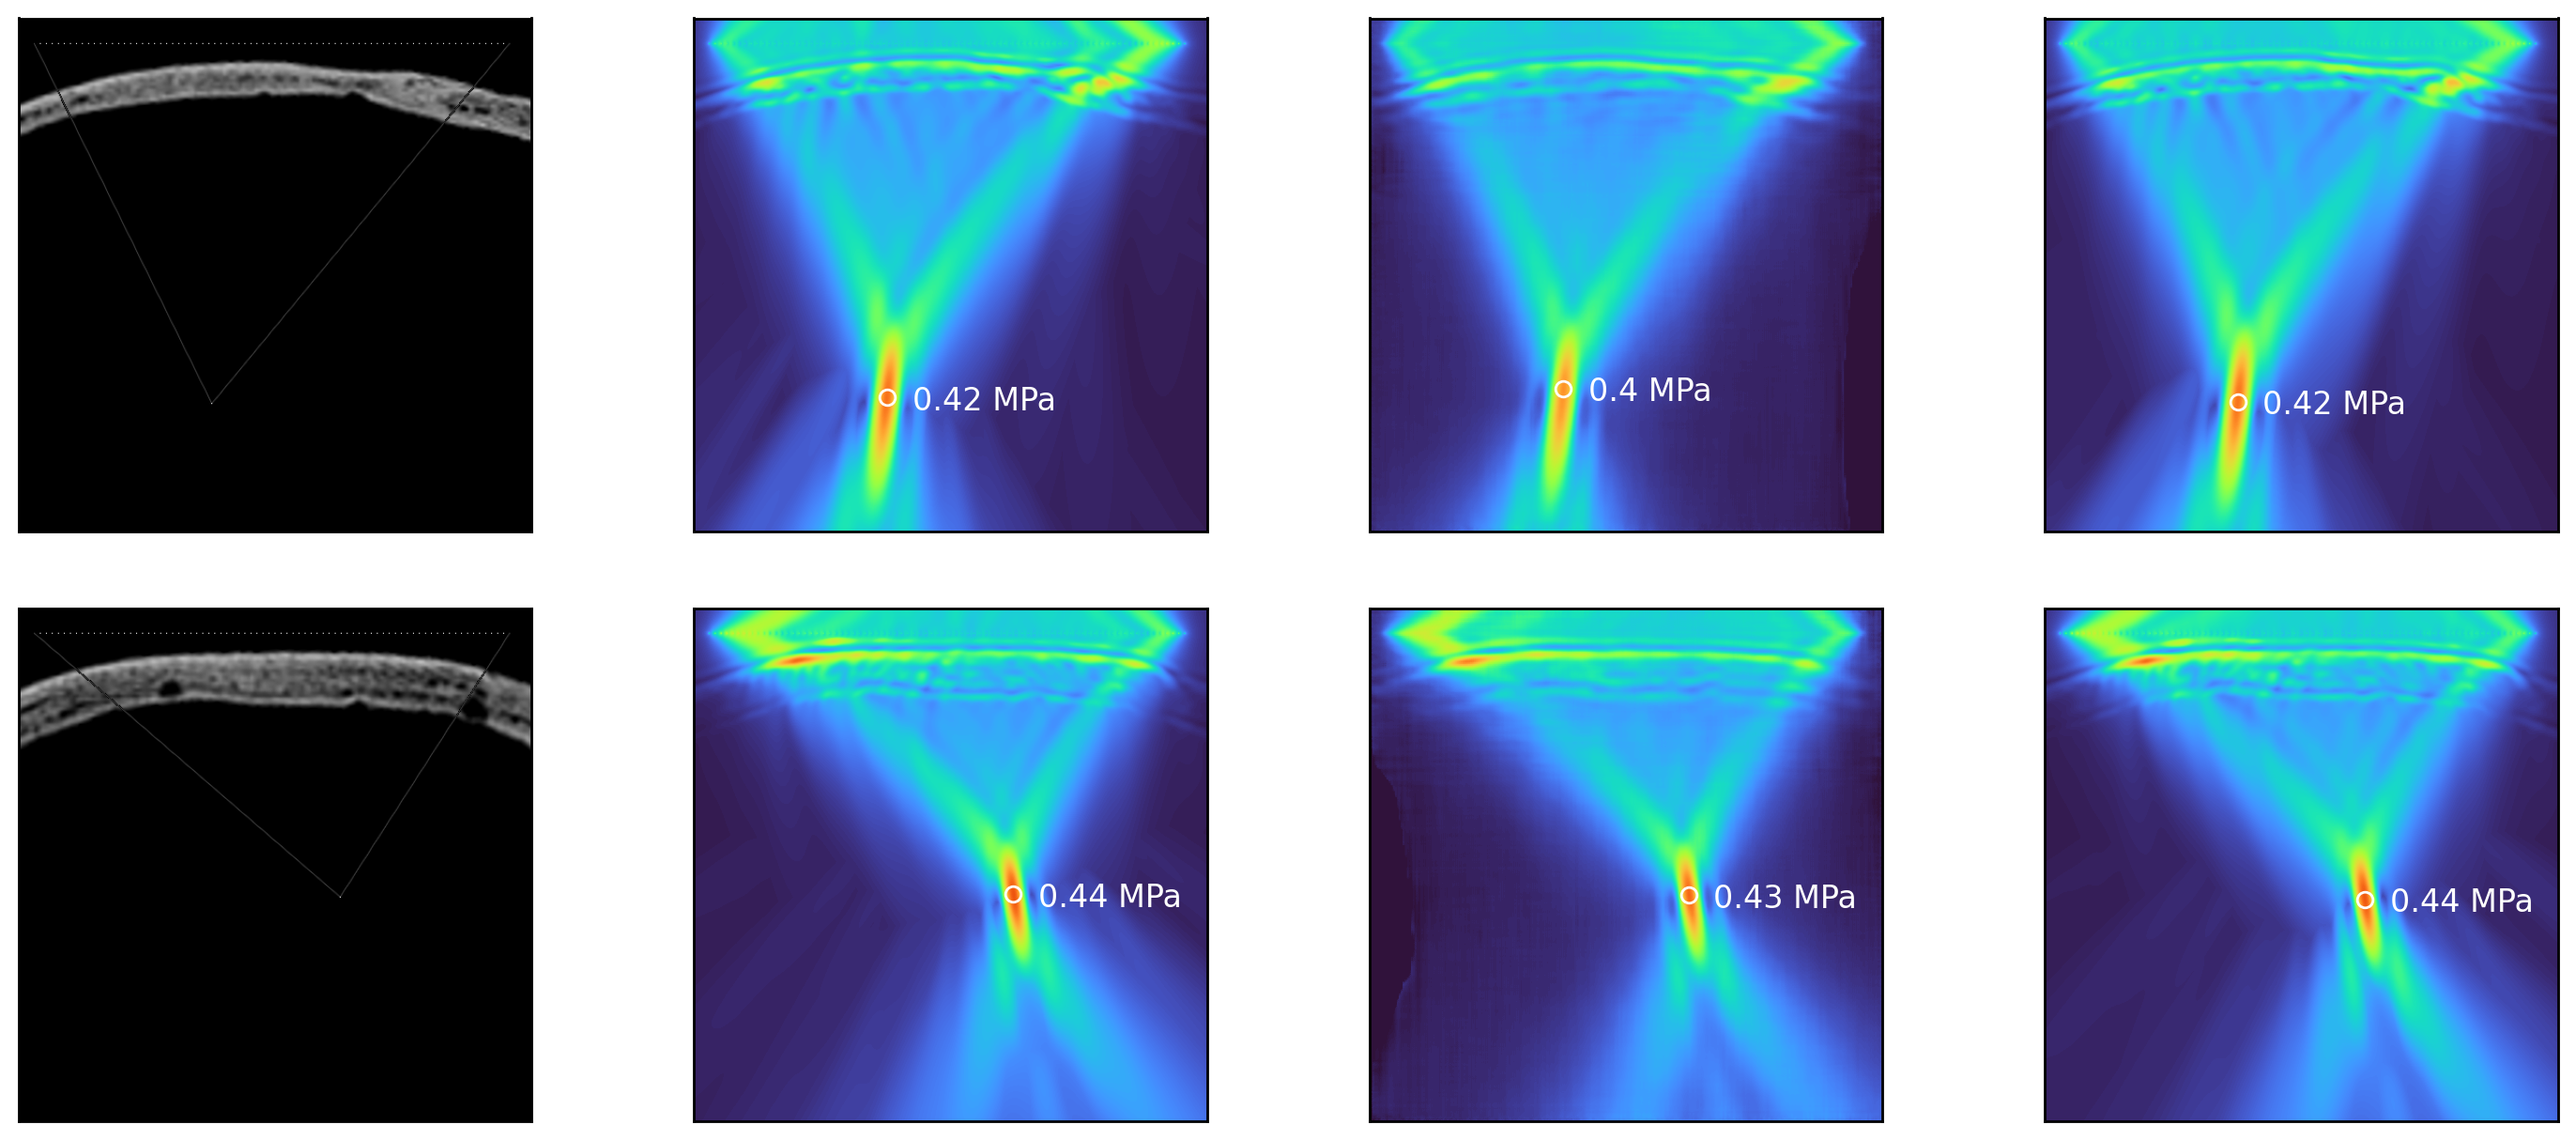

In [15]:
# plot everything together
idx = random.randint(0, 1000)
images = (gt_inputs[idx] / 128 * skull_norm, 
          gt_outputs[idx] * gt_pressures[idx, np.newaxis, np.newaxis] * field_norms_norm / 1e6, 
          net_outputs[idx] * net_pressures[idx, np.newaxis, np.newaxis] * field_norms_norm / 1e6, 
          net_outputs_kw[idx] * net_pressures_kw[idx, np.newaxis, np.newaxis] * field_norms_norm / 1e6)

# visualize examples
fig = visualize_images(images, [""] * 4, n=[2, 1], cbar = False, cmaps = ['gray', 'turbo', 'turbo', 'turbo'], peak = [False, True, True, True], spacing = [0.15, 0.15, 0.15], vmax = 0.55);
fig.savefig(fig_path + "results.png", transparent=True, bbox_inches='tight', pad_inches=0)

## Calculate Metrics

### TUSNet Metrics

Here we compute various metrics comparing TUSNet's outputs to those of k-Wave. The complete function can be found in `metrics.py`. 

In [58]:
(focal_pressure_error, 
 focal_pressure_error_raw, 
 peak_pressure_error, 
 peak_pressure_error_comb, 
 peak_pressure_error_comb_raw,
 focal_location_error, 
 focal_location_error_mhd, 
 focal_location_error_x, 
 focal_location_error_y, 
 focal_volume_error, 
 focal_volume_iou) = tusnet_metrics(gt_outputs, net_outputs, gt_pressures, net_pressures)

### Save Metrics

In [59]:
# Save metrics - TUSNet Pressure Field
np.savez(data_path + "metrics.npz",
         
         focal_pressure_error=focal_pressure_error,
         focal_pressure_error_raw=focal_pressure_error_raw,
         
         peak_pressure_error=peak_pressure_error,
         peak_pressure_error_comb=peak_pressure_error_comb,
         peak_pressure_error_comb_raw=peak_pressure_error_comb_raw,
         
         focal_location_error=focal_location_error,
         focal_location_error_mhd=focal_location_error_mhd,
         focal_location_error_x=focal_location_error_x,
         focal_location_error_y=focal_location_error_y,
         
         focal_volume_error=focal_volume_error,
         focal_volume_iou=focal_volume_iou)